<a href="https://colab.research.google.com/github/haydnllh/pi_c_maths/blob/main/%F0%9F%A4%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my first machine learning program.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import shutil
import math
!pip install -q rembg
import rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#load kaggle handwritten maths symbols dataset
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d xainano/handwrittenmathsymbols
!unzip -q handwrittenmathsymbols.zip
!unrar x -inul -y "data.rar"

 97% 334M/343M [00:03<00:00, 94.7MB/s]
100% 343M/343M [00:03<00:00, 103MB/s] 


In [4]:
def resize(image, d):
  (image_h, image_w) = image.shape
  ar = image_w/image_h
  re_dim = d - d//10
  re_dim_y = int(re_dim*ar)
  re_dim_x = int(re_dim//ar)
  oe = int(not bool(d%2))
  if re_dim_y % 2 == oe:
    re_dim_y += 1
  elif re_dim_x % 2 == oe:
    re_dim_x += 1
  if ar > 1:
    resized = cv2.resize(image, (re_dim,re_dim_x))
  else:
    resized = cv2.resize(image, (re_dim_y,re_dim))
  (re_h,re_w) = resized.shape
  img_box = np.zeros([d,d],"uint8")
  bound_y = round((d-re_h)/2)
  bound_x = round((d-re_w)/2)
  img_box[bound_y:d-bound_y,bound_x:d-bound_x] = resized
  return img_box

In [5]:
#remove background with rembg
#segment image by connected component labeling
def img_segment(image, dimension):
  kernel = np.ones((5, 5), np.uint8)
  (image_width,image_height) = image.shape[:2]
  image_rembg = rembg.remove(image)
  image_rembg = cv2.morphologyEx(image_rembg, cv2.MORPH_OPEN, kernel, iterations = 3)
  gray = cv2.cvtColor(image_rembg, cv2.COLOR_BGR2GRAY)
  blurred = cv2.blur(gray, (7,7))
  thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)[1] #threshold the image
  dilated_image = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
  thresh_transpose = dilated_image.T #do the algorithm column by column
  output = cv2.connectedComponentsWithStats(thresh_transpose, 4, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output
  #storing the components
  component_list = []
  for i in range(1, numLabels):
    bounding_box_x = stats[i, cv2.CC_STAT_LEFT]
    bounding_box_y = stats[i, cv2.CC_STAT_TOP]
    bounding_box_width = stats[i, cv2.CC_STAT_WIDTH]
    bounding_box_height = stats[i, cv2.CC_STAT_HEIGHT]
    bounding_box_area = stats[i, cv2.CC_STAT_AREA]
    bounding_box = labels[bounding_box_y: bounding_box_y + bounding_box_height, bounding_box_x: bounding_box_x + bounding_box_width]
    component = (bounding_box == i).astype("uint8") * 255
    resized = resize(component.T, dimension) #resizing to the desired input size
    print(i-1)
    cv2_imshow(resized)
    resized = np.expand_dims(resized, axis=2)
    input = np.expand_dims(resized, axis=0)
    component_list.append(input)
  return component_list

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 132GB/s]


0


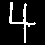

1


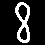

2


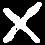

3


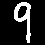

4


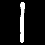

0


1


2


3


4


In [6]:
image = cv2.imread("/content/IMG_1721.jpg")
op_list = img_segment(image,45)
mnist_list = img_segment(image,28)

In [7]:
#process dataset
def function(x,y):
  image = tf.where(x < 10, x, 255)
  return image, y
desired_class = ['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'times', 'div']
path = "/content/extracted_images"
for folders in os.listdir(path):
  if folders not in desired_class:
    shutil.rmtree(os.path.join(path,folders))
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/extracted_images",
    labels = "inferred",
    color_mode = 'grayscale',
    image_size = (45,45),
    batch_size = 1024,
    class_names = desired_class,
    shuffle = True,
    seed = 719,
)
ds_train = ds_train.map(function)
ds_train.cache()

Found 157485 files belonging to 14 classes.


<CacheDataset element_spec=(TensorSpec(shape=(None, 45, 45, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
import tensorflow_datasets as tfds
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [27]:
#defining model
model_mnist = keras.Sequential([
    layers.Conv2D(filters = 8, kernel_size = 5, activation = "relu", padding = 'same', input_shape = [28,28,1]),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = "relu", padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 10, activation = "softmax")
])

In [10]:
model_2 = keras.Sequential([
    layers.Conv2D(filters = 8, kernel_size = 5, activation = "relu", padding = 'same', input_shape = [45,45,1]),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 16, kernel_size = 3, activation = "relu", padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 14, activation = "softmax")
])

In [28]:
#defining optimiser, loss function and metrics
model_mnist.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#fitting
model_mnist.fit(
    x_train,
    y_train,
    epochs = 5,
    verbose = 2
)

Epoch 1/5
1875/1875 - 5s - loss: 0.4280 - accuracy: 0.9335 - 5s/epoch - 3ms/step
Epoch 2/5
1875/1875 - 6s - loss: 0.0740 - accuracy: 0.9782 - 6s/epoch - 3ms/step
Epoch 3/5
1875/1875 - 5s - loss: 0.0550 - accuracy: 0.9830 - 5s/epoch - 3ms/step
Epoch 4/5
1875/1875 - 5s - loss: 0.0475 - accuracy: 0.9853 - 5s/epoch - 2ms/step
Epoch 5/5
1875/1875 - 6s - loss: 0.0402 - accuracy: 0.9871 - 6s/epoch - 3ms/step


In [12]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#fitting
model_2.fit(
    ds_train,
    epochs = 2,
    verbose = 2
)

Epoch 1/2
154/154 - 16s - loss: 5.3346 - accuracy: 0.6358 - 16s/epoch - 107ms/step
Epoch 2/2
154/154 - 13s - loss: 0.6021 - accuracy: 0.8657 - 13s/epoch - 85ms/step


In [29]:
#maths part
numbers, stack, operation_queue = [], [], []
for i in range(len(mnist_list)):
  number = str(np.argmax(model_mnist.predict(mnist_list[i])))
  operator = np.argmax(model_2.predict(op_list[i]))
  if 2 <= operator <= 11:
    stack.append(number)
  else:
    number = int("".join(stack))
    stack.clear()
    numbers.append(number)
    operation_queue.append(operator)
number = int("".join(stack))
stack.clear()
numbers.append(number)
stack.append(numbers[0])
n3 = 0
for i in range(1,len(numbers)):
  n1 = stack.pop()
  n2 = numbers[i]
  match operation_queue.pop(0):
    case 0:
      n3 = n1 + n2
    case 1:
      n3 = n1 - n2
    case 12:
      n3 = n1 * n2
    case 13:
      n3 = n1 / n2
  stack.append(n3)
print("The answer is", stack.pop(), numbers, operation_queue)

1/1 [==============================] - 0s 18ms/step
The answer is 4368 [48, 91] []
